# Forest fire detection

0816064 吳中赫

---

## Import Package

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import cv2
from matplotlib import pyplot as plt
import torch
from pathlib import Path
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.models as model
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from prettytable import PrettyTable

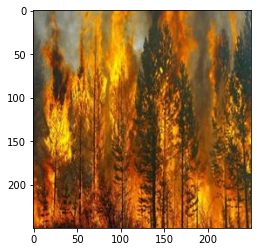

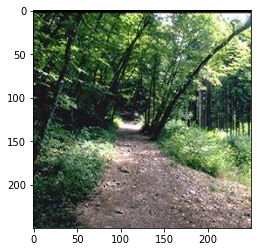

In [2]:
fire_image_path = "Dataset/Dataset/Training and Validation/fire/fire_0078.jpg"
fire_image = cv2.imread(fire_image_path)
fire_image = cv2.cvtColor(fire_image, cv2.COLOR_BGR2RGB)
plt.imshow(fire_image)
plt.show()

nofire_image_path = "Dataset/Dataset/Training and Validation/nofire/nofire_0110.jpg"
nofire_image = cv2.imread(nofire_image_path)
nofire_image = cv2.cvtColor(nofire_image, cv2.COLOR_BGR2RGB)
plt.imshow(nofire_image)
plt.show()

In [3]:
train_path = "Dataset/Dataset/Training and Validation"
test_path = "Dataset/Dataset/Testing"

In [4]:
def preprocessing_img(in_path):
    img_flat = []
    img_list = []
    img_label = []
    cat = ['fire', 'nofire']
    for i in cat:
        path = os.path.join(in_path, i)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img))
            # plt.imshow(img_arr)
            # plt.show()
            img_arr = resize(img_arr,(224,224,3))
            img_flat.append(img_arr.flatten())
            img_list.append(img_arr)
            img_label.append(i)
    return np.array(img_flat), np.array(img_list), np.array(img_label)

train_img_flat, train_img_list, train_img_label = preprocessing_img(train_path)
test_img_flat, test_img_list, test_img_label = preprocessing_img(test_path)

In [5]:
print(train_img_flat.shape)
print(train_img_label.shape)

(1520, 150528)
(1520,)


In [6]:
df_train = pd.DataFrame(train_img_flat)
df_train['label'] = train_img_label
df_test = pd.DataFrame(test_img_flat)
df_test['label'] = test_img_label

df_train

,0,1,2,3,4,5,6,7,8,9,...,150519,150520,150521,150522,150523,150524,150525,150526,150527,label
0,0.037742,0.038652,0.040433,0.049678,0.059899,0.078702,0.005660,0.007745,0.044874,0.006422,...,0.075018,0.067174,0.145606,0.078431,0.070588,0.149020,0.078431,0.070588,0.149020,fire
1,0.012290,0.016387,0.100560,0.012369,0.016466,0.102648,0.013751,0.017980,0.113690,0.014803,...,0.092980,0.038078,0.085137,0.090879,0.035977,0.083036,0.090196,0.035294,0.082353,fire
2,0.109655,0.184165,0.333185,0.116948,0.192744,0.341763,0.115467,0.197496,0.346516,0.124300,...,0.098613,0.137829,0.177044,0.099685,0.142139,0.174877,0.099685,0.142822,0.174195,fire
3,0.002276,0.006893,0.058972,0.002197,0.007108,0.058623,0.001821,0.007108,0.058867,0.001821,...,0.023529,0.015686,0.062745,0.023529,0.015686,0.062745,0.023529,0.015686,0.062745,fire
4,0.763796,0.701050,0.650070,0.764439,0.701694,0.650713,0.767556,0.704810,0.653830,0.769218,...,0.099150,0.224156,0.275298,0.152514,0.268169,0.325667,0.165297,0.279022,0.337846,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0.191661,0.179897,0.160342,0.120200,0.108436,0.089580,0.149911,0.138147,0.118539,0.168118,...,0.135388,0.194344,0.162905,0.206239,0.258585,0.227212,0.166916,0.217896,0.186524,nofire
1516,0.917901,0.925744,0.925744,0.907607,0.915450,0.915450,0.882884,0.890727,0.890727,0.854819,...,0.141356,0.239395,0.223708,0.054237,0.152276,0.136590,0.057686,0.155725,0.140039,nofire
1517,0.319438,0.678174,0.580817,0.263081,0.578086,0.487115,0.284530,0.532206,0.453870,0.325625,...,0.198245,0.188126,0.144989,0.194366,0.193001,0.146625,0.241824,0.249212,0.202153,nofire
1518,0.980392,0.984314,0.976471,0.980392,0.984314,0.976471,0.980392,0.984314,0.976471,0.980392,...,0.068540,0.060697,0.056775,0.073880,0.066036,0.062115,0.067857,0.060014,0.056092,nofire


In [7]:
df_train, df_val =train_test_split(df_train, test_size = 0.3, shuffle = True)
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']
X_val = df_val.drop(['label'], axis=1)
y_val = df_val['label']
X_test = df_test.drop(['label'], axis = 1)
y_test = df_test['label']
print(df_train.shape)
print(df_val.shape)

(1064, 150529)
(456, 150529)


In [8]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_val_pred = svm.predict(X_val)
y_test_pred = svm.predict(X_test)

In [9]:
##### SVM Validation #####
print("##### SVM Validation #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_val, y_val_pred)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_val, y_val_pred, average=None))
myTable.add_column("Recall", recall_score(y_val, y_val_pred, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_val, y_val_pred))
print(df_cm)

##### SVM Validation #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.9232456140350878 | 0.9032258064516129 | 0.9333333333333333 |
| nofire | 0.9232456140350878 | 0.9414225941422594 | 0.9146341463414634 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  196   14
1   21  225


In [10]:
##### SVM Test #####
print("##### SVM Test #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_test, y_test_pred)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_test, y_test_pred, average=None))
myTable.add_column("Recall", recall_score(y_test, y_test_pred, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
print(df_cm)

##### SVM Test #####
+--------+-------------------+--------------------+--------------------+
| label  |      Accuracy     |     Precision      |       Recall       |
+--------+-------------------+--------------------+--------------------+
|  fire  | 0.868421052631579 |        0.85        | 0.8947368421052632 |
| nofire | 0.868421052631579 | 0.8888888888888888 | 0.8421052631578947 |
+--------+-------------------+--------------------+--------------------+
     0    1
0  170   20
1   30  160


---

In [11]:
RF = RandomForestClassifier(n_estimators=30, max_depth = 30)
RF.fit(X_train, y_train)
y_val_pred = RF.predict(X_val)
y_test_pred = RF.predict(X_test)

In [12]:
##### Random Forest Validation #####
print("##### Random Forest Validation #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_val, y_val_pred)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_val, y_val_pred, average=None))
myTable.add_column("Recall", recall_score(y_val, y_val_pred, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_val, y_val_pred))
print(df_cm)

##### Random Forest Validation #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.8618421052631579 | 0.8418604651162791 | 0.861904761904762  |
| nofire | 0.8618421052631579 | 0.8796680497925311 | 0.8617886178861789 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  181   29
1   34  212


In [13]:
##### Random Forest Test #####
print("##### Random Forest Test #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_test, y_test_pred)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_test, y_test_pred, average=None))
myTable.add_column("Recall", recall_score(y_test, y_test_pred, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
print(df_cm)

##### Random Forest Test #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.8473684210526315 | 0.8548387096774194 | 0.8368421052631579 |
| nofire | 0.8473684210526315 | 0.8402061855670103 | 0.8578947368421053 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  159   31
1   27  163


---

In [14]:
Train = Path(train_path)
Test = Path(test_path)

trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [15]:
train_val_data = datasets.ImageFolder(Train, transform=trans)
test_data = datasets.ImageFolder(Test, transform=trans)
print(train_val_data.class_to_idx)
classes = ['fire', 'nofire']

# print(len(train_val_data))
train_size = int(len(train_val_data)*0.7)
val_size = len(train_val_data) - train_size

train_data, val_data = random_split(train_val_data, [train_size, val_size])
print("train_data size: ", len(train_data))
print("val_data size: ", len(val_data))

{'fire': 0, 'nofire': 1}
train_data size:  1064
val_data size:  456


In [16]:
batch_size = 5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride = 1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(16, 8, kernel_size=11, stride = 1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(8*50*50, 2)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
#
model = CNN_Model().to(device)
print(model)


Using cuda device
CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(current)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(correct)
        
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [20]:
epoch = 5
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val(val_loader, model, loss_fn)
    # scheduler.step()
print("Done!")

Epoch 1
-------------------------------
0
loss: 0.714283  [    0/ 1064]
500
loss: 0.170877  [  500/ 1064]
1000
loss: 0.222842  [ 1000/ 1064]
0.9276315789473685
Test Error: 
 Accuracy: 92.8%, Avg loss: 0.181354 

Epoch 2
-------------------------------
0
loss: 0.042425  [    0/ 1064]
500
loss: 0.078819  [  500/ 1064]
1000
loss: 0.514044  [ 1000/ 1064]
0.9364035087719298
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.160275 

Epoch 3
-------------------------------
0
loss: 0.030218  [    0/ 1064]
500
loss: 0.159289  [  500/ 1064]
1000
loss: 0.092095  [ 1000/ 1064]
0.9407894736842105
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.145879 

Epoch 4
-------------------------------
0
loss: 0.316593  [    0/ 1064]
500
loss: 0.085981  [  500/ 1064]
1000
loss: 0.173264  [ 1000/ 1064]
0.9407894736842105
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.139045 

Epoch 5
-------------------------------
0
loss: 0.017899  [    0/ 1064]
500
loss: 0.006756  [  500/ 1064]
1000
loss: 0.086534  [ 1000/ 1064]
0.923245614

In [21]:
torch.save(model.state_dict(), 'save.pt')

In [22]:
y_pred_list = []
y_list = []
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # print("pred: ", pred)
        # print("real: ", y)

        _, predicted = torch.max(pred.data, 1)
        # print(predicted.tolist())
        # print(y.tolist())
        y_list.extend(y.tolist())
        y_pred_list.extend(predicted.tolist())

        # total += y.size(0)
        # correct += (predicted == y).sum().item()

# print(f'Accuracy of the network on the 380 test images: {100 * correct // total} %')
##### CNN Test #####
print("##### CNN Validation #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_list, y_pred_list)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_list, y_pred_list, average=None))
myTable.add_column("Recall", recall_score(y_list, y_pred_list, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_list, y_pred_list))
print(df_cm)

##### CNN Validation #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.9232456140350878 | 0.9807692307692307 | 0.8680851063829788 |
| nofire | 0.9232456140350878 |       0.875        | 0.9819004524886877 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  204   31
1    4  217


In [23]:
y_pred_list = []
y_list = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # print("pred: ", pred)
        # print("real: ", y)

        _, predicted = torch.max(pred.data, 1)
        # print(predicted.tolist())
        # print(y.tolist())
        y_list.extend(y.tolist())
        y_pred_list.extend(predicted.tolist())

        # total += y.size(0)
        # correct += (predicted == y).sum().item()

# print(f'Accuracy of the network on the 380 test images: {100 * correct // total} %')
##### CNN Test #####
print("##### CNN Test #####")
myTable = PrettyTable()
myTable.add_column("label", ['fire', 'nofire'])
tmp = accuracy_score(y_list, y_pred_list)
myTable.add_column("Accuracy", [tmp, tmp])
myTable.add_column("Precision",  precision_score(y_list, y_pred_list, average=None))
myTable.add_column("Recall", recall_score(y_list, y_pred_list, average=None))
print(myTable)
df_cm = pd.DataFrame(confusion_matrix(y_list, y_pred_list))
print(df_cm)

##### CNN Test #####
+--------+--------------------+--------------------+--------------------+
| label  |      Accuracy      |     Precision      |       Recall       |
+--------+--------------------+--------------------+--------------------+
|  fire  | 0.8789473684210526 |        0.95        |        0.8         |
| nofire | 0.8789473684210526 | 0.8272727272727273 | 0.9578947368421052 |
+--------+--------------------+--------------------+--------------------+
     0    1
0  152   38
1    8  182


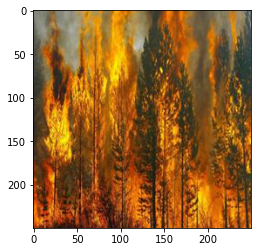

The image is predicted to be 98.69% fire


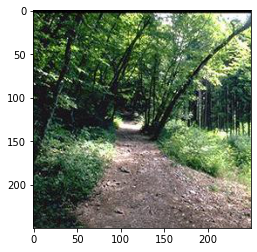

The image is predicted to be 99.94% nofire


In [24]:
with torch.no_grad():
    ##### fire #####
    img = Image.open(fire_image_path)
    plt.imshow(img)
    plt.show()
    img_tensor = trans(img).to(device).unsqueeze(0)
    pred = model(img_tensor)
    _, predicted = torch.max(pred.data, 1)
    # print(pred)
    # print(classes[predicted])
    lab = classes[predicted]
    probs = F.softmax(pred, dim = 1)
    probs = np.round(float(probs.max())*100, 2)
    print("The image is predicted to be {}% {}".format(probs, lab))
    ##### nofire #####
    img = Image.open(nofire_image_path)
    plt.imshow(img)
    plt.show()
    img_tensor = trans(img).to(device).unsqueeze(0)
    pred = model(img_tensor)
    _, predicted = torch.max(pred.data, 1)
    # print(pred)
    # print(classes[predicted])
    lab = classes[predicted]
    probs = F.softmax(pred, dim = 1)
    probs = np.round(float(probs.max())*100, 2)
    print("The image is predicted to be {}% {}".format(probs, lab))


In [25]:
def video_detection(input_video_path, model_path, trans):
    loaded_model = CNN_Model().to(device)
    loaded_model.load_state_dict(torch.load(model_path))
    print(loaded_model)
    
    # if not os.path.exists("frame_folder"):
    #     os.mkdir("frame_folder")
    
    video = cv2.VideoCapture(input_video_path)
    if not video.isOpened():
        print("Fail to open video.")
    ##### Write video #####        
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'MPV4')
    out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (width,  height))

    index = 0
    while(video.isOpened()):
        ret, frame = video.read()
        if(ret == False): 
            break
        # print(frame.shape)
        ##### convert frame to png #####
        # png_file = 'eval_' + str(index) + '.png'
        # png_path = 'frame_folder/' + png_file
        # index += 1
        # cv2.imwrite(png_path, frame)
        ##### Prediction using png #####
        # img = Image.open(png_path)
        # img_tensor = trans(img).to(device).unsqueeze(0)
        # pred = model(img_tensor)
        # _, predicted = torch.max(pred.data, 1)
        # lab = classes[predicted]
        # probs = F.softmax(pred, dim = 1)
        # probs = np.round(float(probs.max())*100, 2)
        # text = "The image is predicted to be {}% {}".format(probs, lab)
        ##### Prediction using frame #####
        vid_array = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        vid_image = Image.fromarray(vid_array)
        vid_image = trans(vid_image).to(device).unsqueeze(0)
        pred = model(vid_image)
        _, predicted = torch.max(pred.data, 1)
        lab = classes[predicted]
        probs = F.softmax(pred, dim = 1)
        probs = np.round(float(probs.max())*100, 2)
        text = "{}% {}".format(probs, lab)
        ##### Write text #####
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, text, (50, 50), font, 1, (0, 255, 255), 2, cv2.LINE_4)
        out.write(frame)
        cv2.imshow('windows', frame)
        ##### press q to stop ##### 
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break 
    
    video.release()
    cv2.destroyAllWindows()


In [26]:
video_detection("video2.mp4", "save.pt", trans)

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)


In [27]:
video_detection(0, "save.pt", trans)

CNN_Model(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)
